In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# ToF data
data1 = np.load('tof_1hz.npy', allow_pickle=True)
X_train1 = data1[:, 0].reshape(-1, 1)
Y_train1 = data1[:, [2, 3]]
alphas1 = np.ones_like(Y_train1[:, 0]) * 0.15
print(X_train1.shape, Y_train1.shape, alphas1.shape)

# RSSI data
data2 = np.load('RSSI_5hz.npy', allow_pickle=True)
X_train2 = data2[:, 0].reshape(-1, 1)
Y_train2 = data2[:, [2, 3]]
alphas2 = np.ones_like(Y_train2[:, 0]) * 1.0
print(X_train2.shape, Y_train2.shape, alphas2.shape)

# Combined data
X_train3 = np.vstack((X_train1, X_train2))
Y_train3 = np.vstack((Y_train1, Y_train2))
alphas3 = np.ones_like(Y_train3[:, 0]) * 1.0
alphas4 = np.hstack((alphas1, alphas2))
print(X_train3.shape, Y_train3.shape, alphas3.shape)

# simulation data
real_pos = np.load('real_position.npy', allow_pickle=True)



(20, 1) (20, 2) (20,)
(97, 1) (97, 2) (97,)
(117, 1) (117, 2) (117,)


0.29500710933882013


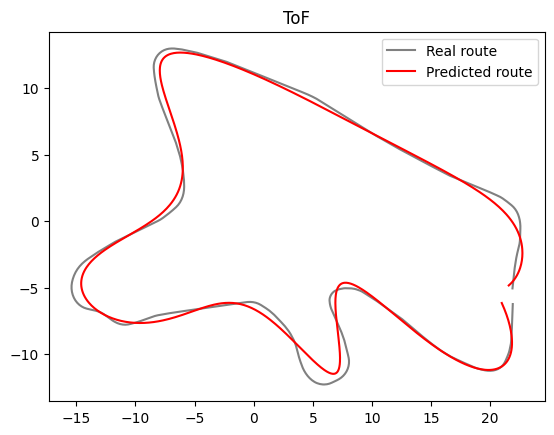

In [4]:
# ToF data prediction

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_error as mae

kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1000.0))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alphas1, random_state=0, n_restarts_optimizer=100)

gpr.fit(X_train1, Y_train1)
pred = gpr.predict(real_pos[:, 0].reshape(-1, 1))
print(mae(real_pos[:, [2, 3]], pred))

plt.plot(real_pos[:, 2], real_pos[:, 3], 'grey')
plt.plot(pred[:, 0], pred[:, 1], 'red')
plt.legend(['Real route', 'Predicted route'])
plt.title('ToF')
plt.savefig('ToF_route.png')


0.3974392004137993


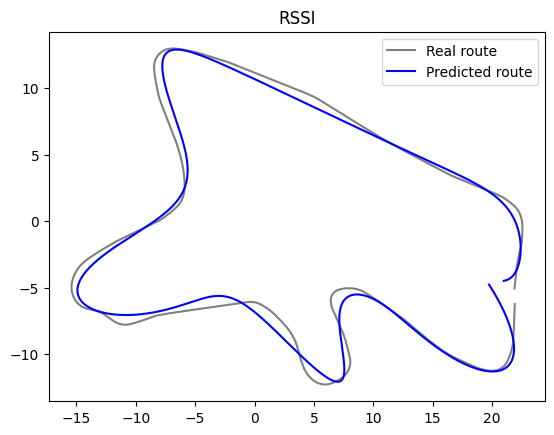

In [7]:
# RSSI data prediction

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_error as mae

kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1000.0))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alphas2, random_state=0, n_restarts_optimizer=100)

gpr.fit(X_train2, Y_train2)
pred = gpr.predict(real_pos[:, 0].reshape(-1, 1))
print(mae(real_pos[:, [2, 3]], pred))

plt.plot(real_pos[:, 2], real_pos[:, 3], 'grey')
plt.plot(pred[:, 0], pred[:, 1], 'blue')
plt.legend(['Real route', 'Predicted route'])
plt.title('RSSI')
plt.savefig('RSSI_route.png')


0.3532687027899519


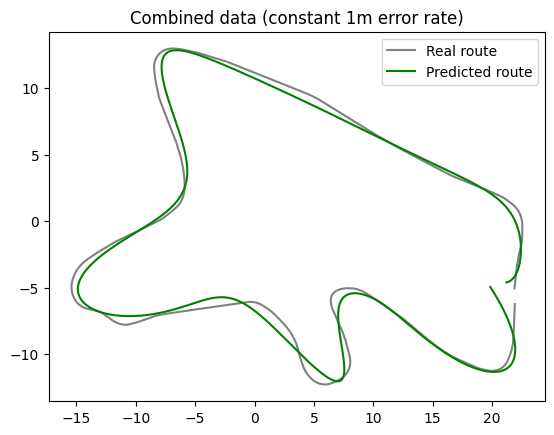

In [8]:
# Combined data prediction (constant error rate)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_error as mae

kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1000.0))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alphas3, random_state=0, n_restarts_optimizer=100)

gpr.fit(X_train3, Y_train3)
pred = gpr.predict(real_pos[:, 0].reshape(-1, 1))
print(mae(real_pos[:, [2, 3]], pred))

plt.plot(real_pos[:, 2], real_pos[:, 3], 'grey')
plt.plot(pred[:, 0], pred[:, 1], 'green')
plt.legend(['Real route', 'Predicted route'])
plt.title('Combined data (constant 1m error rate)')
plt.savefig('Combined_constant_route.png')


0.24442030676707516


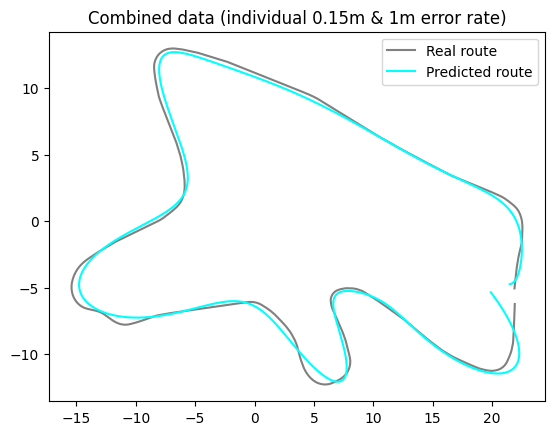

In [11]:
# Combined data prediction (individual error rate)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_error as mae

kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1000.0))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alphas4, random_state=0, n_restarts_optimizer=100)

gpr.fit(X_train3, Y_train3)
pred = gpr.predict(real_pos[:, 0].reshape(-1, 1))
print(mae(real_pos[:, [2, 3]], pred))

plt.plot(real_pos[:, 2], real_pos[:, 3], 'grey')
plt.plot(pred[:, 0], pred[:, 1], 'cyan')
plt.legend(['Real route', 'Predicted route'])
plt.title('Combined data (individual 0.15m & 1m error rate)')
plt.savefig('Combined_individual_route.png')


[3.43603844 8.35615367]


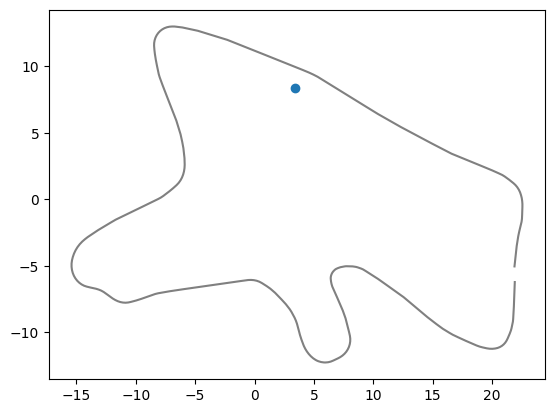

[3.45961336 9.66586957]


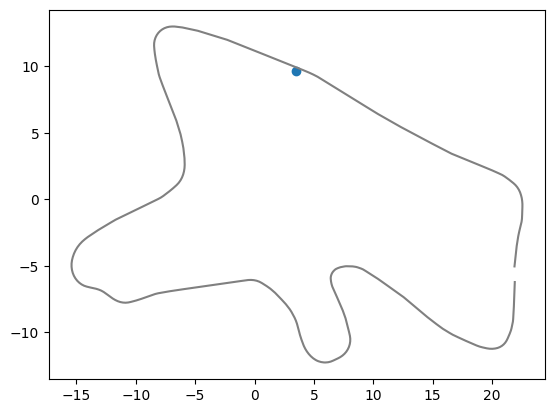

[3.27753786 9.74839171]


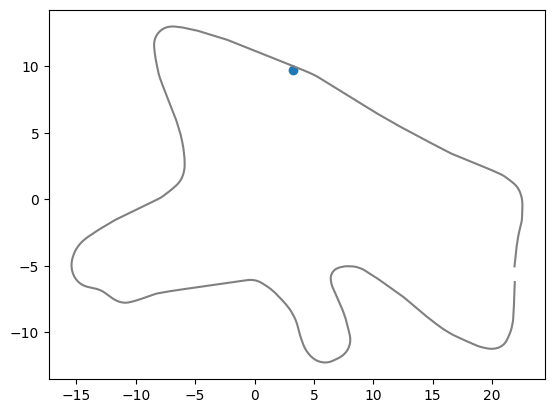

[3.09576037 9.83091513]


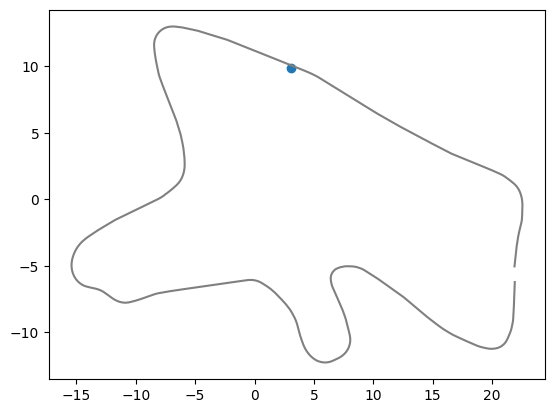

[2.91430243 9.91343445]


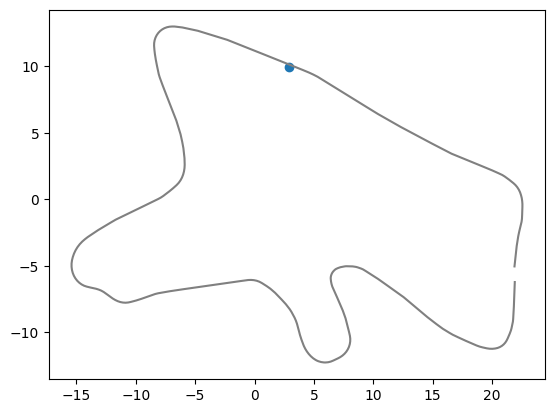

[2.73318547 9.99594415]


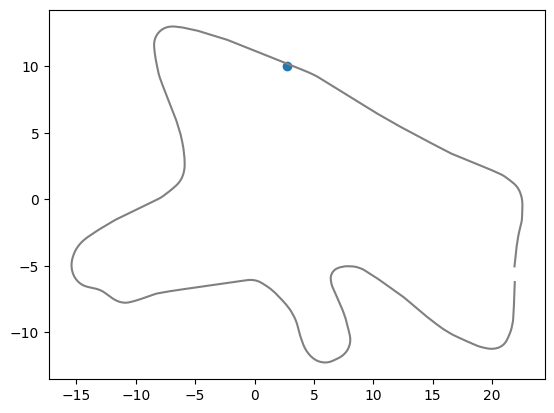

KeyboardInterrupt: 

In [31]:
# Real-time prediction
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1000.0))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alphas3, random_state=0, n_restarts_optimizer=100)


for i in range(200, real_pos.shape[0]):
    limit1 = np.argwhere(data1[:, 0] < real_pos[i, 0])[:, 0]
    limit2 = np.argwhere(data2[:, 0] < real_pos[i, 0])[:, 0]

    X_train = np.vstack((X_train1[limit1], X_train2[limit2]))
    Y_train = np.vstack((Y_train1[limit1], Y_train2[limit2]))

    alphas = np.hstack((alphas1[limit1].ravel(), alphas2[limit2].ravel()))


    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alphas, random_state=0, n_restarts_optimizer=100)
    gpr.fit(X_train, Y_train)
    pred = gpr.predict(real_pos[i, 0].reshape(1, -11))[0]
    print(pred)

    plt.plot(real_pos[:, 2], real_pos[:, 3], 'grey')
    plt.scatter(pred[0], pred[1])
    plt.show()
    
